In [2]:
import pandas as pd
import numpy as np

In [ ]:
# 1.假设：因子和label呈线性关系
# 2.把因子转化成仓位，用仓位计算净值曲线，IC/IR

In [5]:
# 构建一个因子
d = pd.read_feather('/Users/aming/project/python/crypto-workstation-v2/非线性因子相关性的发现/2h_future/橡胶主连_adj_20170104_20251127__kline_2h.feather')
# d.set_index(d['datetime'],inplace=True)

In [7]:
d.set_index('datetime',inplace=True)
d


,open,high,low,close,highest,lowest,average,volume,amount,open_interest,symbol
datetime,,,,,,,,,,,
2017-01-04 10:00:00,18325.000000,18330.000000,17825.000000,17890.000000,18540.000000,17820.000000,18215.900391,70027.0,1.262946e+10,5023.0,SHFE.ru1705
2017-01-04 12:00:00,17870.000000,18420.000000,17870.000000,18420.000000,18540.000000,17820.000000,18184.800781,59027.0,1.068817e+10,-439.0,SHFE.ru1705
2017-01-04 14:00:00,18450.000000,18500.000000,18325.000000,18460.000000,18540.000000,17820.000000,18214.400391,30343.0,5.587786e+09,2565.0,SHFE.ru1705
2017-01-04 16:00:00,18465.000000,18650.000000,18365.000000,18530.000000,18650.000000,17820.000000,18268.400391,54240.0,1.003637e+10,94.0,SHFE.ru1705
2017-01-04 22:00:00,18505.000000,18540.000000,18335.000000,18495.000000,18540.000000,18335.000000,18438.199219,45975.0,8.476789e+09,-1432.0,SHFE.ru1705
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-27 12:00:00,4607.349121,4628.518555,4601.300781,4608.861328,4630.030762,4583.155762,4602.298828,38108.0,5.812351e+09,-2424.0,SHFE.ru2601
2025-11-27 14:00:00,4613.397461,4623.982422,4611.885742,4620.958008,4630.030762,4583.155762,4603.478516,11135.0,1.700207e+09,-76.0,SHFE.ru2601
2025-11-27 16:00:00,4622.470215,4630.030762,4602.812988,4620.958008,4631.542969,4583.155762,4605.776855,25936.0,3.961247e+09,-2100.0,SHFE.ru2601


In [9]:
def make_reversal_factor_and_label(df: pd.DataFrame, horizon: int = 2):
    out = pd.DataFrame(index=df.index)

    # 1) 计算单期收益（t-1 -> t）
    ret1 = df["close"].pct_change(1)

    # # 2) 计算过去20期波动率
    # vol20 = ret1.rolling(20).std()

    # 3) 反转强度因子：-（上一期收益 / 波动率）
    #    直觉：涨得越猛越可能回吐，跌得越猛越可能反弹
    # out["factor_reversal"] = -(ret1 / vol20)
    out["factor_reversal"] = ret1  # 一个周期的收益率大小直接作为因子

    # 4) label：未来2期收益（t -> t+horizon）
    out["label_fwd_ret10"] = df["close"].pct_change(horizon).shift(-horizon)  # label:未来2个周期的收益率

    # 去掉无法计算的行
    out = out.replace([np.inf, -np.inf], np.nan).dropna()

    return out

In [10]:
out = make_reversal_factor_and_label(d)

In [11]:
out

,factor_reversal,label_fwd_ret10
datetime,,
2017-01-04 12:00:00,0.029626,0.005972
2017-01-04 14:00:00,0.002172,0.001896
2017-01-04 16:00:00,0.003792,-0.005397
2017-01-04 22:00:00,-0.001889,-0.018924
2017-01-05 00:00:00,-0.003514,-0.002170
...,...,...
2025-11-27 00:00:00,-0.002626,0.002962
2025-11-27 10:00:00,0.002632,0.002954
2025-11-27 12:00:00,0.000328,0.002625


In [16]:
def bin_test(df_factor_label: pd.DataFrame, n_bins: int = 1):
    tmp = df_factor_label.copy()

    tmp["bin"] = pd.qcut(tmp["factor_reversal"], n_bins, labels=False)

    # 每箱未来收益均值
    bin_mean = tmp.groupby("bin")["label_fwd_ret10"].mean()

    # top - bottom spread
    spread = bin_mean.iloc[-1] - bin_mean.iloc[0]

    return bin_mean, spread

bin_mean, spread = bin_test(out, n_bins=10)
print("每箱未来2期收益均值：\n", bin_mean)
print("\nTop-Bottom Spread:", spread)

每箱未来2期收益均值：
 bin
0   -0.000104
1    0.000056
2   -0.000194
3   -0.000239
4   -0.000279
5    0.000099
6   -0.000243
7   -0.000220
8   -0.000122
9   -0.000422
Name: label_fwd_ret10, dtype: float32

Top-Bottom Spread: -0.00031759893


In [ ]:
# 1.为什么有的因子ic很低，但是可以有很大的实用价值？
# 2.只在因子值很大的时候对收益率有预测作用，因子的有效性不是对称的
# 3.ic分析的是整体的线性单调关系，但是因子真正有效的那一部分的值只在尾部（某些区间上），整体的相关性会被中间的噪声稀释到0
# 4.分箱 条件过滤（在某一段时间波动率低的时候 ，价格出现突破，此时行情动量延续的概率更大）

<Axes: xlabel='bin'>

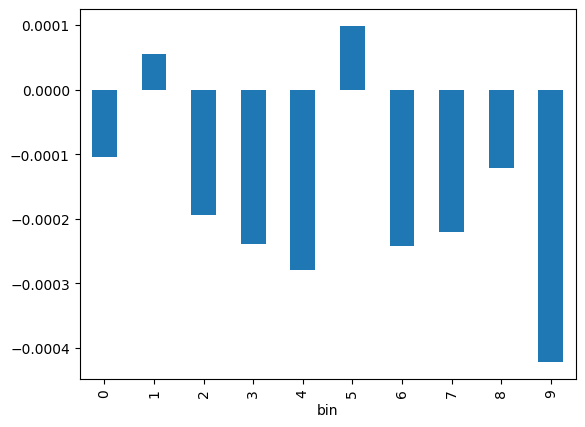

In [17]:
bin_mean.plot(kind='bar')
# 1.看一下这个因子在单品种上有多少交易机会？
# 2.如果纳入更多的品种，那么平均单品种交易机会？

In [18]:
from sklearn.feature_selection import mutual_info_regression
# 尝试用numpy把mutual info自己写一遍
X = out[["factor_reversal"]].values
y = out["label_fwd_ret10"].values

mi = mutual_info_regression(X, y, random_state=0)[0]
print("MI(factor, future_ret10) =", mi)

MI(factor, future_ret10) = 0.11908517780353556


In [19]:
X_true = out[["factor_reversal"]].values
y = out["label_fwd_ret10"].values

# 生成噪声因子：打乱 factor
X_noise = np.random.permutation(X_true)  # 生成噪音序列

mi_true = mutual_info_regression(X_true, y, random_state=0)[0]
mi_noise = mutual_info_regression(X_noise, y, random_state=0)[0]

print("MI(true) =", mi_true)
print("MI(noise) =", mi_noise)
print("Ratio true/noise =", mi_true / (mi_noise + 1e-12))

MI(true) = 0.11908517780353556
MI(noise) = 0.003321338019209641
Ratio true/noise = 35.85457941315439


In [47]:
# x, y 都是一维数组 / Series，长度一致
import dcor
x = out["factor_reversal"].values
y = out["label_fwd_ret10"].values

d = dcor.distance_correlation(x.reshape(-1, 1), y.reshape(-1, 1))
print("Distance Correlation (dCor) =", float(d))

c:\Users\puppy\miniconda3\envs\myenv\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float32, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Distance Correlation (dCor) = 0.059683725376783583


In [ ]:
# 1.mi或dcor检验是否有相关性 2.通过排序，发现哪些因子相关性靠前 